### Preservation of linear invariants for the linear advection problem

In [1]:
using Revise
using LinearAlgebra
using InvariantDA
import TransportBasedInference: StateSpace, AdditiveInflation, Model, SyntheticData, 
                                Localization, MultiplicativeInflation, MultiAddInflation,
                                periodicmetric!, rmse, spread, metric_hist, seqassim
using Statistics
using Distributions
using FFTW
using JLD
using FileIO
using ProgressMeter
using SparseArrays
using OrdinaryDiffEq
using SciMLOperators

Load some packages to make nice figures

In [2]:
using CairoMakie
using LaTeXStrings
using ColorSchemes
using NamedColors

Define the dimension of the state and observation vectors

In [3]:
Nx = 128
Ny = 32

32

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.01
Δtobs = 0.2

0.2

Define the time span of interest $(t_0, t_f)$

In [5]:
t0 = 0.0
Tf = 2000
tf = Tf*Δtobs

400.0

Setup parameters for the linear advection problem

In [6]:
L = 1.0
c = 1.0
Δx = L/Nx
xgrid = collect(Δx*(0:1:Nx-1))
    
params = Dict("N" => Nx,
              "L" => L,
              "c" => c,
              "plan" => plan_rfft(zeros(Nx)),
              "c∂x" => map(k-> k == Nx÷2 ? 0.0*im : c*(2*π*im*k/L), 0:Nx÷2))

Dict{String, Any} with 5 entries:
  "c"    => 1.0
  "c∂x"  => ComplexF64[0.0+0.0im, 0.0+6.28319im, 0.0+12.5664im, 0.0+18.8496im, …
  "N"    => 128
  "L"    => 1.0
  "plan" => FFTW real-to-complex plan for 128-element array of Float64…

In [7]:
cfl = c*Δtdyn/Δx

1.28

In [8]:
π0 = MvNormal(zeros(Nx), I)

IsoNormal(
dim: 128
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [9]:
πmass = Normal(1.0, 0.1)
αk = 1.0

1.0

Linear invariant, i.e., mass to preserve

In [10]:
m0 = rand(πmass)

1.0347014862073338

Routine to generate smooth and periodic initial condition $x_0$ with linear invariants $U_\perp^\top x_0  = C_{\perp}$:\
See preprint for details

In [11]:
function initial_condition(m, ϕm::Vector{Float64}, αk, Δx, Nx::Int64)
    
    @assert isapprox(norm(ϕm), 1.0, atol = 1000*eps())
        
    xparallel = irfft((randn(Nx÷2+1) + im*randn(Nx÷2+1)).* map(k-> exp(-0.5*k^αk), 1:Nx÷2+1), Nx)/Δx
    
    return ϕm*m + xparallel - ϕm*dot(ϕm, xparallel)
end

initial_condition (generic function with 1 method)

Vector $U_\perp$ defining the linear invariant

In [12]:
Uperp = ones(Nx)/sqrt(Nx);

Generate ground truth initial condition 

In [13]:
x0 = initial_condition(m0, Uperp, αk, Δx, Nx);

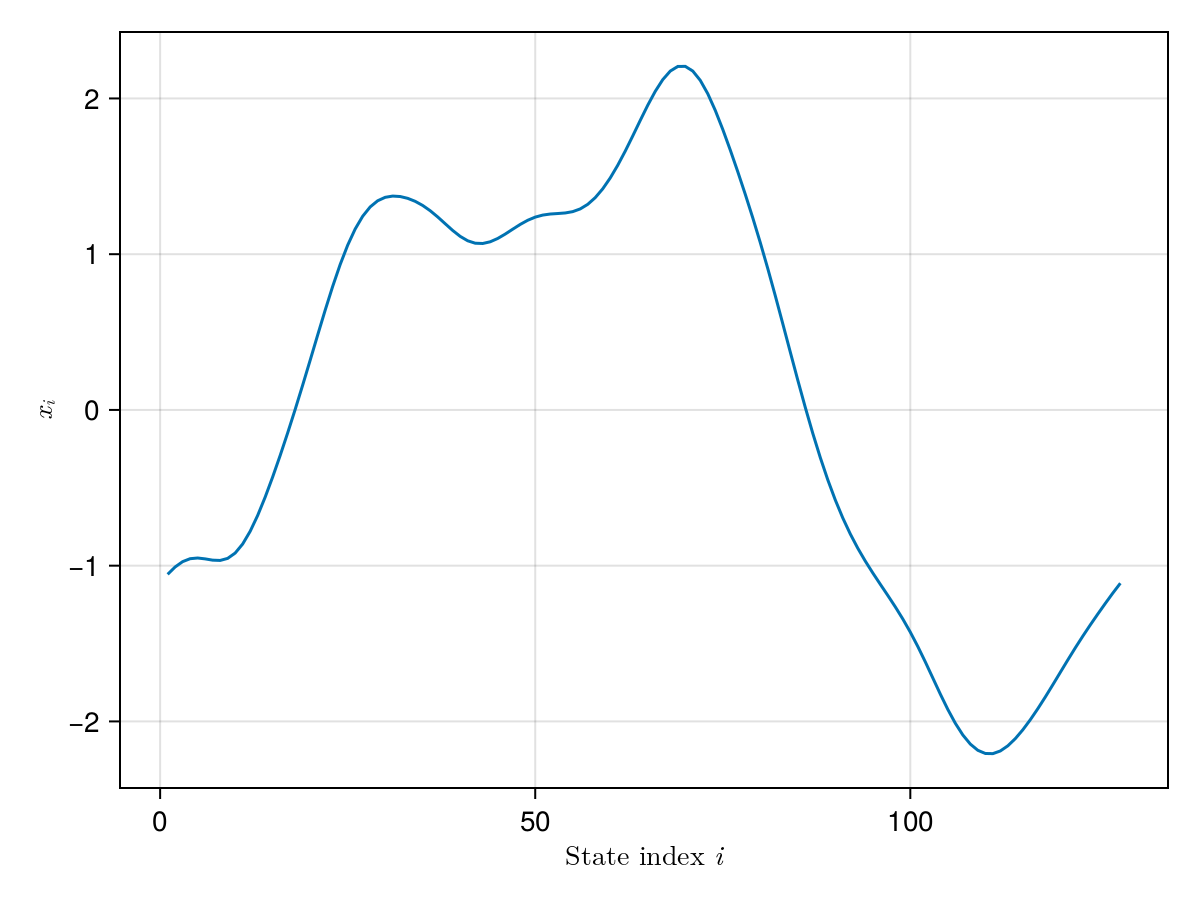

In [14]:
fig = Figure()

ax = Axis(fig[1,1],
          xlabel = L"\text{State index }i",
          ylabel = L"x_i")

lines!(ax, x0)

fig

Define dynamical and observation operators

In [15]:
h(x, t) = x[1:4:end]
H = Matrix(1.0*I, Nx, Nx)[1:4:end,:]
F = StateSpace((du, u, p, t) -> spectral_linear_advection!(du, u, params, t), h)

StateSpace(var"#5#6"(), TransportBasedInference.var"#24#25"(), h)

`ϵx` defines the additive noise applied between the forecast step and the analysis step. The process noise is applied before to sample from the likelihood model.

`ϵy` defines the additive observation noise. 

We assume that the noise distributions are Gaussian.

In [16]:
σx = 0.01
σy = 0.1

ϵx = DegenerateAdditiveInflation(Nx, zeros(Nx), σx, Uperp)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(32, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010000000000000002 0.0 … 0.0 0.0; 0.0 0.010000000000000002 … 0.0 0.0; … ; 0.0 0.0 … 0.010000000000000002 0.0; 0.0 0.0 … 0.0 0.010000000000000002], [0.1 0.0 … 0.0 0.0; 0.0 0.1 … 0.0 0.0; … ; 0.0 0.0 … 0.1 0.0; 0.0 0.0 … 0.0 0.1])

Define a wrapper for all the settings of the data assimilation problem

In [17]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

For the twin-experiment, we use the function `generate_data_rfft` to integrate forward in time the linear advection problem, and generate the observations that will be later assimilated in the ensemble filter. This function can easily be modified for your specific needs.

In [18]:
data = generate_data_rfft(model, x0, Tf);

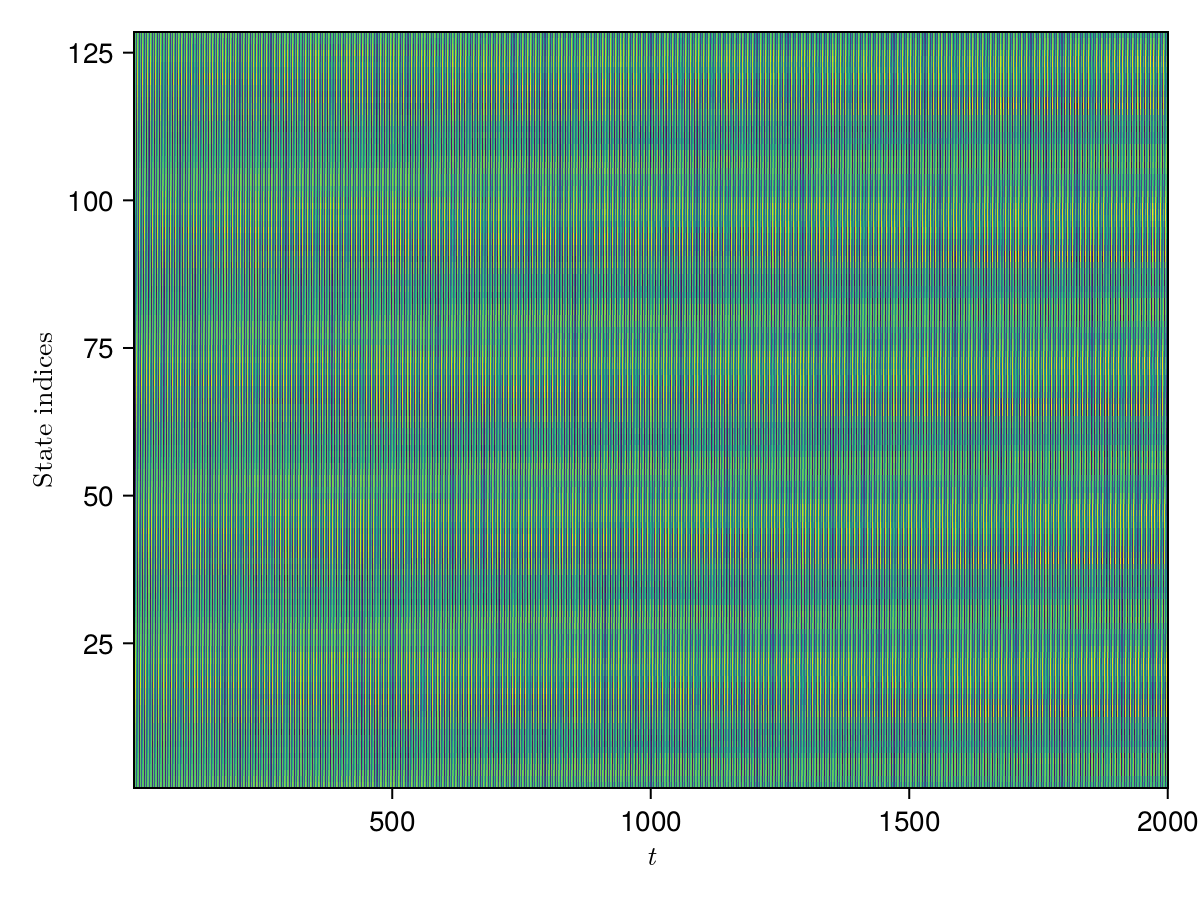

In [19]:
fig = Figure()

ax = Axis(fig[1,1],
          xlabel = L"t",
          ylabel = L"\text{State indices}")

heatmap!(ax, data.xt')

resize_to_layout!(fig)

fig

In the core library `TransportBasedInference` used in this work, we use the following convention to store the state and observation variables. The state and observation variables of the different ensemble members are stored in a common matrix `X`. The different columns store the different samples. The first entries of a column contains the observation variables, while the latter contains the state variables. This convention might seem confusing at first, but it is very convenient for conditional density estimation with triangular transport methods.

Define localization parameters

In [20]:
Δ = 4
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

@assert length(yidx) == Ny

# Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Gyy (generic function with 1 method)

Define semi-empirical ensemble Kalman filter with localization. This filter expects a linear observation matrix `H`.

In [21]:
Lrad = 5
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

enkf = LocEnKF(model.ϵy, model.Δtdyn, model.Δtobs, Loc, H)

Localized EnKF with filtered = false


Define multiplicative and additive inflation preserving linear invariants in the span of $U_\perp$

In [22]:
β = 1.01
ϵxβ = MultiDegenAddInflation(β, zeros(Nx), σx, Uperp)

MultiDegenAddInflation(128, 1.01, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01], OrthoProjector([0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843  …  0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843, 0.08838834764831843]))

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [23]:
Ne = 40# ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
for i=1:Ne
    X[Ny+1:Ny+Nx,i] = initial_condition(m0, Uperp, αk, Δx, Nx)
end

Apply the sequential filter over the time window

In [24]:
Xenkf = seqassim_rfft(F, data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


Compute the RMSE of the unconstrained ensemble Kalman filter

In [25]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.0651980039983941

In [26]:
Xenkf_mass = seqassim_rfft_project_mass(F, data, Tf, ϵxβ, Uperp, enkf, deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


Compute the RMSE of the constrained ensemble Kalman filter

In [27]:
rmse_enkf_mass = mean(map(i->norm(data.xt[:,i]-mean(Xenkf_mass[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.06346852054417149

In [28]:
100*(rmse_enkf - rmse_enkf_mass)/rmse_enkf

2.6526631923658384

Evolution of the linear invariant, i.e., mass, over time

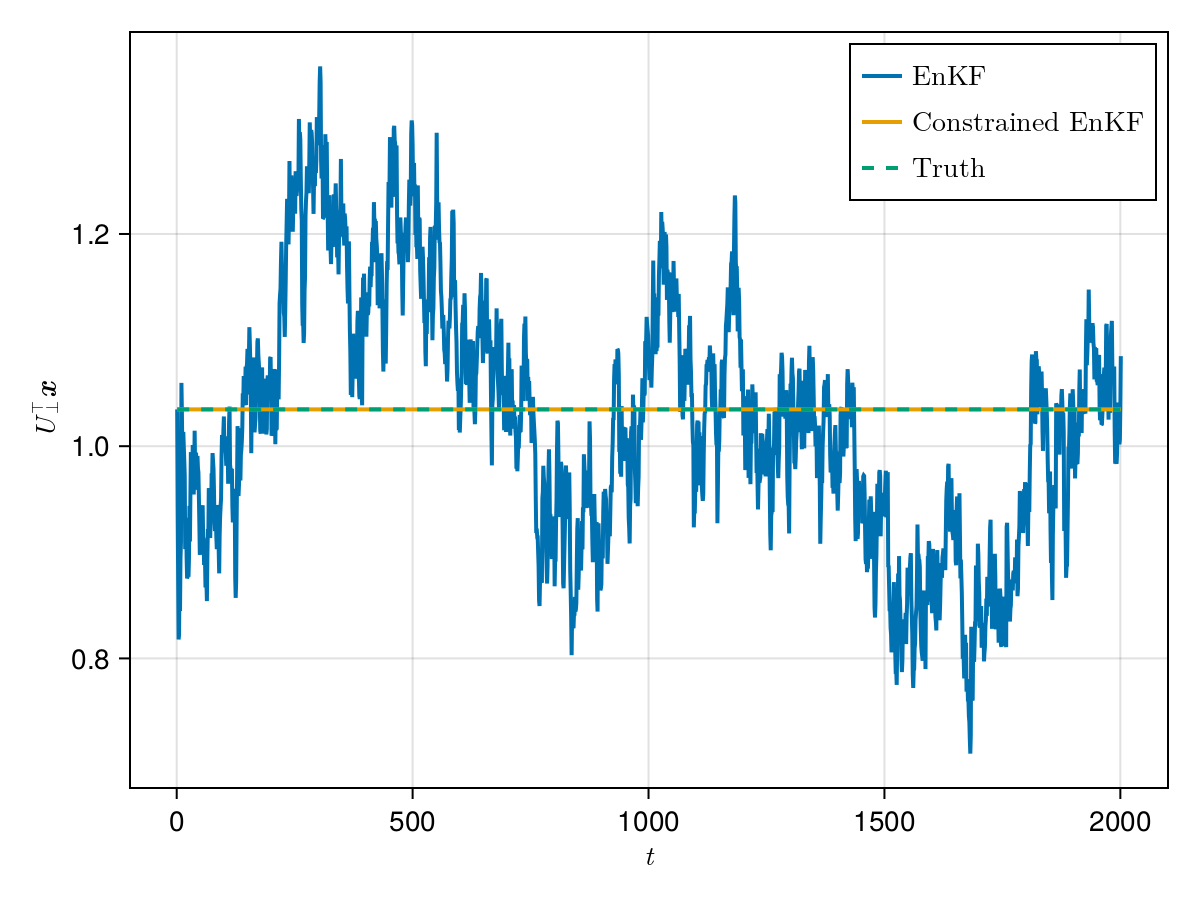

In [29]:
fig = Figure()

ax = Axis(fig[1,1],
          xlabel = L"t",
          ylabel = L"U_{\perp}^\top \mathbf{x}")

lines!(ax, vcat(map(i-> mean(Xenkf[i];dims = 2)'*Uperp[:,1], 1:Tf+1)...),
      linewidth = 2, label = L"\text{EnKF}")
lines!(ax, vcat(map(i-> mean(Xenkf_mass[i];dims = 2)'*Uperp[:,1], 1:Tf+1)...),
      linewidth = 2, label = L"\text{Constrained EnKF}")
lines!(ax, data.xt'*Uperp[:,1], linewidth = 2, 
       linestyle = :dash, label = L"\text{Truth}")


axislegend()
resize_to_layout!(fig)
fig

Snapshot of the reconstruction at $t = 1000 \Delta t_{obs}$

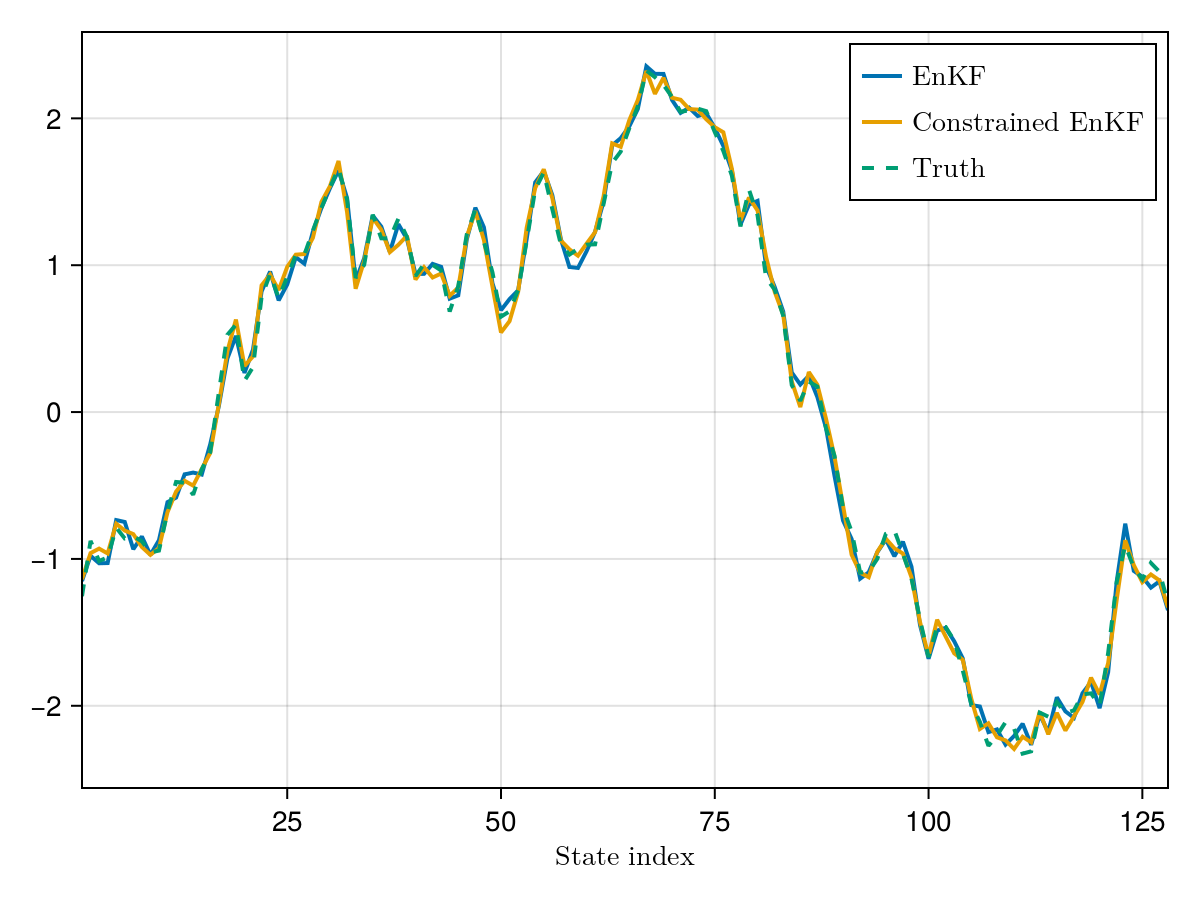

In [30]:
fig = Figure()

idx_snap = 1000

ax = Axis(fig[1,1],
          xlabel = L"\text{State index}")

lines!(ax, mean(Xenkf[idx_snap+1];dims = 2)[:,1], label = L"\text{EnKF}",
      linewidth = 2)
lines!(ax, mean(Xenkf_mass[idx_snap+1];dims = 2)[:,1], label = L"\text{Constrained EnKF}",
      linewidth = 2)

lines!(ax, data.xt[:,idx_snap], label = L"\text{Truth}", linewidth = 2, linestyle = :dash)

axislegend()

resize_to_layout!(fig)

xlims!(ax, 1, Nx)


fig

Evolution of the RMSE over time

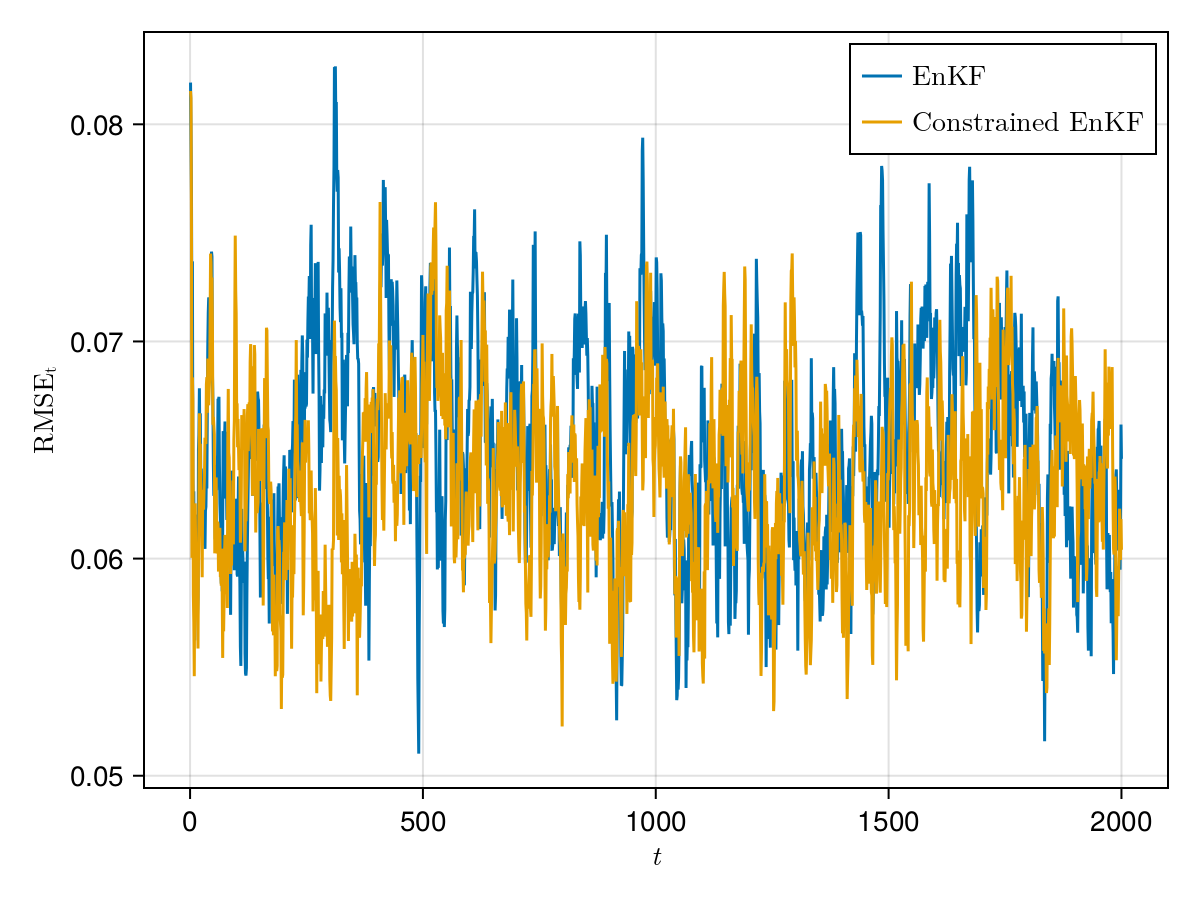

In [31]:
fig = Figure()

ax = Axis(fig[1,1],
          xlabel = L"t",
          ylabel = L"\text{RMSE_t}")

lines!(ax, map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf), 
       label = L"\text{EnKF}")
lines!(ax, map(i->norm(data.xt[:,i]-mean(Xenkf_mass[i+1]; dims = 2))/sqrt(Nx), 1:Tf),
       label = L"\text{Constrained EnKF}")

axislegend()
resize_to_layout!(fig)
fig